# Time Series ECG Anomaly Detection w Autoencoders

# Acknowledgment

refer to https://www.kaggle.com/code/mdtamjidhossain/time-series-ecg-anomaly-detection-w-autoencoders ,and made changes

In [1]:
# arff to pandas
#!pip install arff2pandas

In [2]:
#Setup Gdrive file download extention 
#!conda install -y gdown

In [3]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
#from arff2pandas import a2p

from scipy.io import arff

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style= 'whitegrid', palette= 'muted', font_scale= 1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Data¶
The dataset contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. Source

We have 5 types of hearbeats (classes):

* Normal (N)
* R-on-T Premature Ventricular Contraction (R-on-T PVC)
* Premature Ventricular Contraction (PVC)
* Supra-ventricular Premature or Ectopic Beat (SP or EB)
* Unclassified Beat (UB).
Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. Frequency: 60–100 per minute (Humans) Duration: 0.6–1 second (Humans) Source

In [4]:
# !gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

In [5]:
# !unzip -qq ECG5000.zip

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # if gpu is available use gpu

In [7]:
# convert arff to pandas
# with open('ECG5000_TRAIN.arff') as f:
#  train = a2p.load(f)
# with open('ECG5000_TEST.arff') as f:
#  test = a2p.load(f)

data, _= arff.loadarff('ECG5000_TRAIN.arff')
train = pd.DataFrame(data)
train['target'] = train['target'].apply(lambda x: int(x.decode('utf-8')))

data, _= arff.loadarff('ECG5000_TEST.arff')
test = pd.DataFrame(data)
test['target'] = test['target'].apply(lambda x: int(x.decode('utf-8')))


In [8]:
train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


In [9]:
test.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,0.334577,...,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073,1
1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,-0.397999,...,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009,1
2,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,-1.440680,...,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767,1
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,...,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853,1
4,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,-0.521316,...,1.280823,1.494315,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784,1


In [10]:
# df = train.append(test)
df = pd.concat([train, test], ignore_index=False)
df = df.sample(frac=1.0)      # shuffling dataframe
df.shape

(5000, 141)

In [11]:
CLASS_NORMAL = 1

class_names = ['Normal', 'R on T', 'PVC', 'SP', 'UB']

# Data Preprocessing

In [12]:
#changing name of the target column

new_columns = list(df.columns)
new_columns[-1] = 'target'    
df.columns =new_columns
df.columns

Index(['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9',
       'att10',
       ...
       'att132', 'att133', 'att134', 'att135', 'att136', 'att137', 'att138',
       'att139', 'att140', 'target'],
      dtype='object', length=141)

# Data Exploration

In [13]:
# total examples in each class
df.target.value_counts()

target
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64

In [14]:
# checking class imbalance
ax = sns.countplot(df.target)
x = np.arange(len(class_names))

# 设置 x 轴刻度为固定位置
ax.set_xticks(x)
# 设置 x 轴刻度标签
ax.set_xticklabels(class_names)

[Text(0, 0, 'Normal'),
 Text(1, 0, 'R on T'),
 Text(2, 0, 'PVC'),
 Text(3, 0, 'SP'),
 Text(4, 0, 'UB')]

In [15]:
# checking mean values of each class
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )                                             # standard deviation
  ax.set_title(class_name)

In [16]:
# mean value of each column
'''df[df.target == str(CLASS_NORMAL)] \
    .drop(labels = 'target', axis = 1) \
    .mean(axis = 0).shape'''

"df[df.target == str(CLASS_NORMAL)]     .drop(labels = 'target', axis = 1)     .mean(axis = 0).shape"

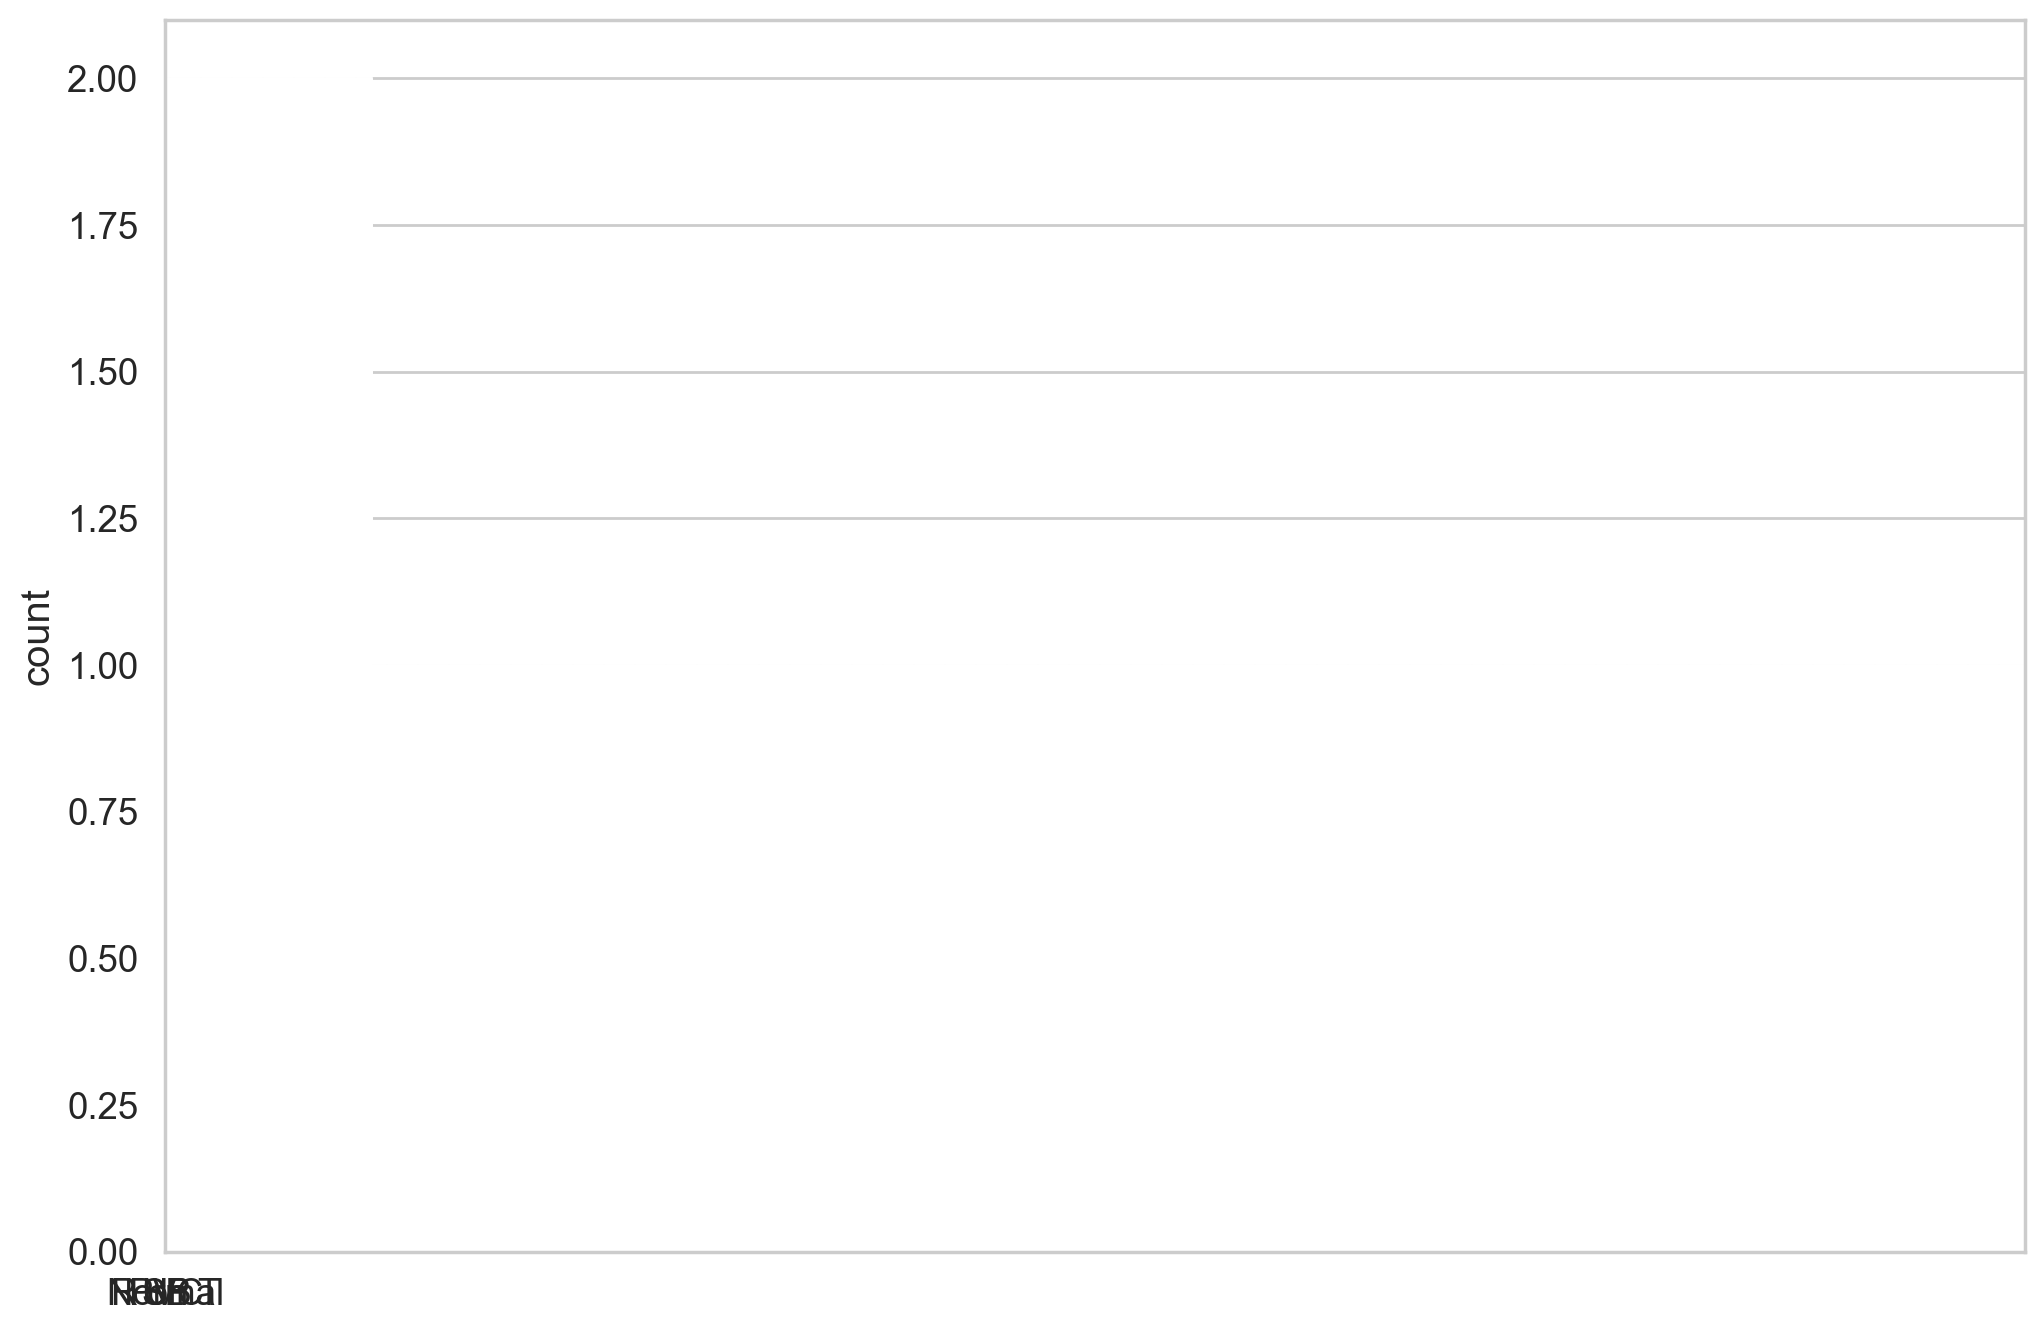

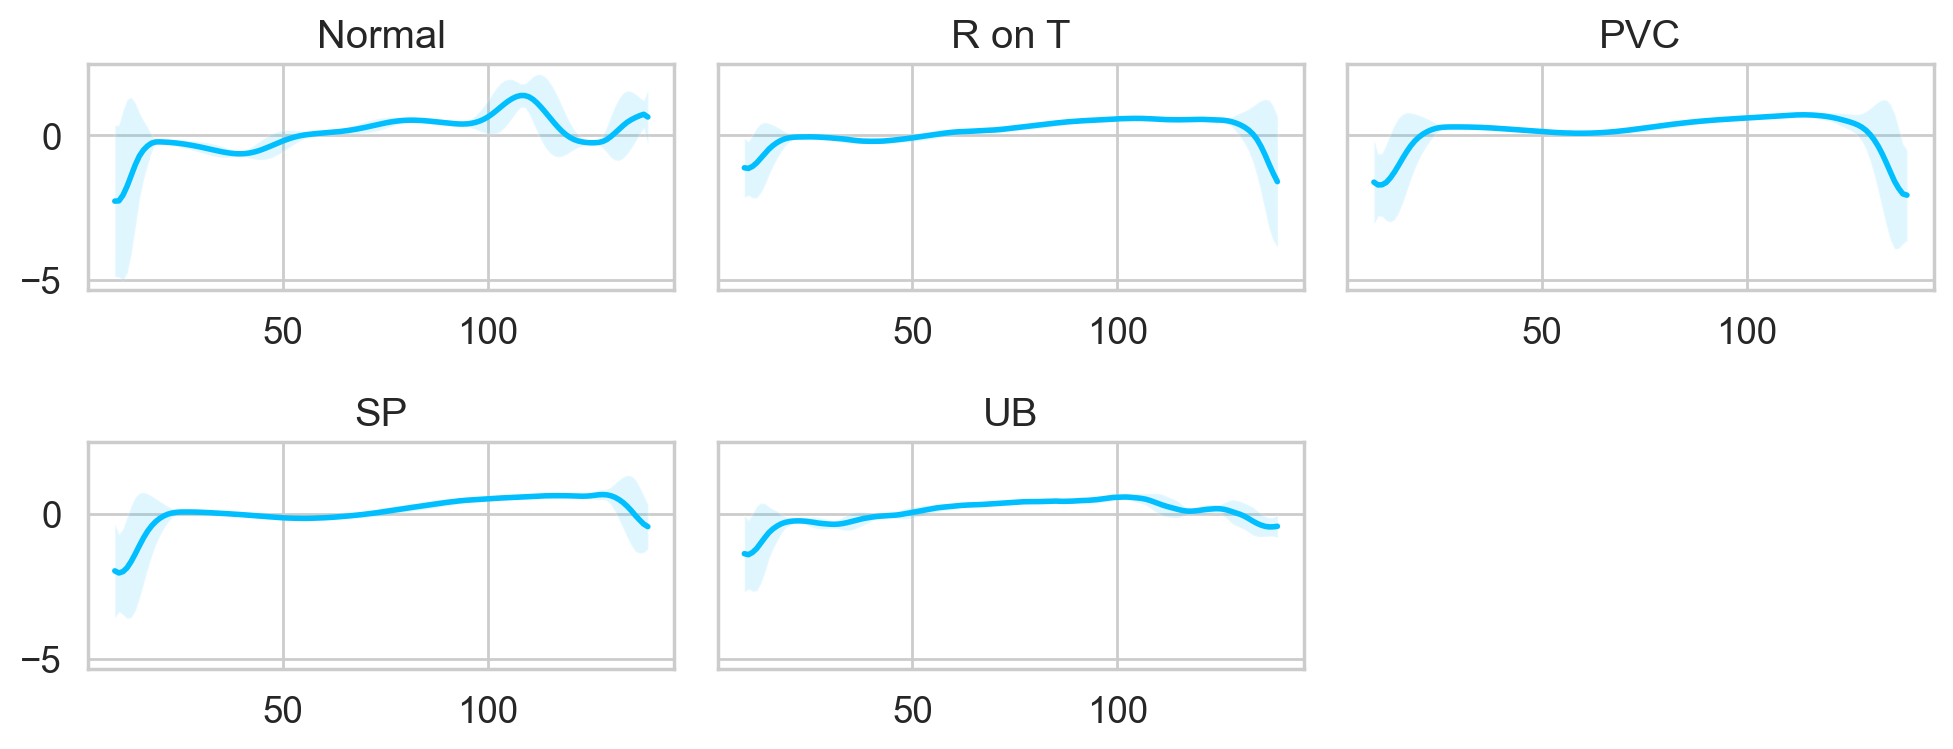

In [17]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(10, 4)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()                         # taking mean value for each column by axis = 0
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])               # deleting last axis cause we only have 5 classes
fig.tight_layout();
plt.show()

Less opacity areas denote standard deviation from the mean values.

# Data Preprocessing

Getting all normal heartbeats and dropping the target (class) column:

In [19]:
df.target 

1001    1
2086    1
2153    1
555     1
205     1
       ..
3926    2
466     2
2592    1
3272    2
360     1
Name: target, Length: 5000, dtype: int64

In [20]:
normal_df = df[df.target == CLASS_NORMAL].drop(labels='target', axis = 1)
normal_df.shape

(2919, 140)

Merging all other classes and mark them as anomalies ; dropping labels:

In [21]:
anomaly_df = df[df.target != CLASS_NORMAL].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

Splitting the normal examples into train, validation and test sets:

In [22]:
# shuffling not needed, did already

# splitting normal dataset to train & val
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state= RANDOM_SEED)

# splitting val dataframe to val & test
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state= RANDOM_SEED)

In [23]:
test_df.shape

(219, 140)

In [24]:
# list of np arrays 
train_sequences = train_df.astype(np.float32).to_numpy().tolist()
val_sequences = val_df.astype(np.float32).to_numpy().tolist()
test_sequences = test_df.astype(np.float32).to_numpy().tolist()
anomaly_sequences = anomaly_df.astype(np.float32).to_numpy().tolist()

Need to convert the examples into tensors, so we can use them to train our Autoencoder. The helper function for that:

In [25]:
# converting sequences to torch tensors
# training model single example at a time so that batch size is 1

def create_dataset(sequences):
  
  dataset = [torch.tensor(s).unsqueeze(1) for s in sequences] # converting each sequence to a tensor & adding a dimension

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features (140x1 in our case).

Creating some datasets:

In [26]:
# creating tensors

train_dataset, seq_len, n_features = create_dataset(train_sequences)

val_dataset, seq_len, n_features = create_dataset(val_sequences)

test_dataset, seq_len, n_features = create_dataset(test_sequences)

test_anomaly_dataset, seq_len, n_features = create_dataset(anomaly_sequences)

In [27]:
test_normal_dataset, seq_len, n_features = create_dataset(test_sequences)

# Building an LSTM Autoencoder

The general Autoencoder architecture consists of two components. An Encoder that compresses the input and a Decoder that tries to reconstruct it.

Autoencoder's job is to learn the pattern from data. This is learned by learning how to represent the data using some lowering of the dimensionality of the data. Autoencoder compresses and reconstructs the data.

* We will train on normal heartbeats, autoencoder understands how normal heartbeats look like.
* Then we pass heartbeats with anomalies, autoencoder will not be able to reconstruct those data.
* We can measure the reconstruction error then, when the error is high, we can tell there is an anomaly.
> Reconstruction error tells how well the data is understood by autoencoder.

Using the LSTM Autoencoder from this GitHub repo with some small tweaks. The model’s job is to reconstruct Time Series data.

In [28]:
# using Recurrent Autoencoder and tweaking with a linear layer into the decoder

class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))   # (batch_size, seq_len, num of features)

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))  # num of units/neurons into the hidden layer

The Encoder uses two LSTM layers to compress the Time Series data input.

Decoding the compressed representation using a Decoder:

In [29]:
# passing in results from the encoder

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    # outputting univariate time series with 140 predictions
    self.output_layer = nn.Linear(self.hidden_dim, n_features)  # dense output layer; contains 140 examples

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))    # reshaping

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

The Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Wrapping everything into an easy to use module:

In [30]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [31]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)        # moving model to gpu

# Training

In [32]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)     # summing error; L1Loss = mean absolute error in torch
  
  history = dict(train=[], val=[])                      # recording loss history

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []

    for seq_true in train_dataset:     # iterate over each seq for train data
      optimizer.zero_grad()            # no accumulation

      seq_true = seq_true.to(device)   # putting sequence to gpu
      seq_pred = model(seq_true)       # prediction

      loss = criterion(seq_pred, seq_true)  # measuring error

      loss.backward()                  # backprop
      optimizer.step()

      train_losses.append(loss.item())  # record loss by adding to training losses

    val_losses = []
    model = model.eval()
    with torch.no_grad():  # requesting pytorch to record any gradient for this block of code
      for seq_true in val_dataset:
          seq_true = seq_true.to(device)   # putting sequence to gpu
          seq_pred = model(seq_true)       # prediction

          loss = criterion(seq_pred, seq_true)  # recording loss

          val_losses.append(loss.item())    # storing loss into the validation losses
    train_loss = np.mean(train_losses)   # computing loss on training and val data for this epoch
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train loss = {train_loss}, val loss = {val_loss}')

  return model.eval(), history      # after training, returning model to evaluation mode

In [33]:
model, history = train_model(model, train_dataset, val_dataset, n_epochs= 150)

Epoch 1: train loss = 75.443049429694, val loss = 56.23193962062331
Epoch 2: train loss = 53.90633369885544, val loss = 51.33479375273125
Epoch 3: train loss = 58.08616757729226, val loss = 56.34700846563191
Epoch 4: train loss = 55.35566685748456, val loss = 55.287225279089526
Epoch 5: train loss = 54.87222781290887, val loss = 54.4493241331893
Epoch 6: train loss = 53.06007649791861, val loss = 54.90981773480977
Epoch 7: train loss = 54.78451442449432, val loss = 54.3259743120028
Epoch 8: train loss = 53.98616506629584, val loss = 52.82672479707901
Epoch 9: train loss = 53.27236748049212, val loss = 54.79608394675059
Epoch 10: train loss = 53.4536198797076, val loss = 50.13494310422575
Epoch 11: train loss = 46.74951885612393, val loss = 46.45414666824689
Epoch 12: train loss = 45.03374229348124, val loss = 50.07235585391249
Epoch 13: train loss = 44.65535735545837, val loss = 50.568492009759495
Epoch 14: train loss = 44.598024250278065, val loss = 49.91812729508909
Epoch 15: train l

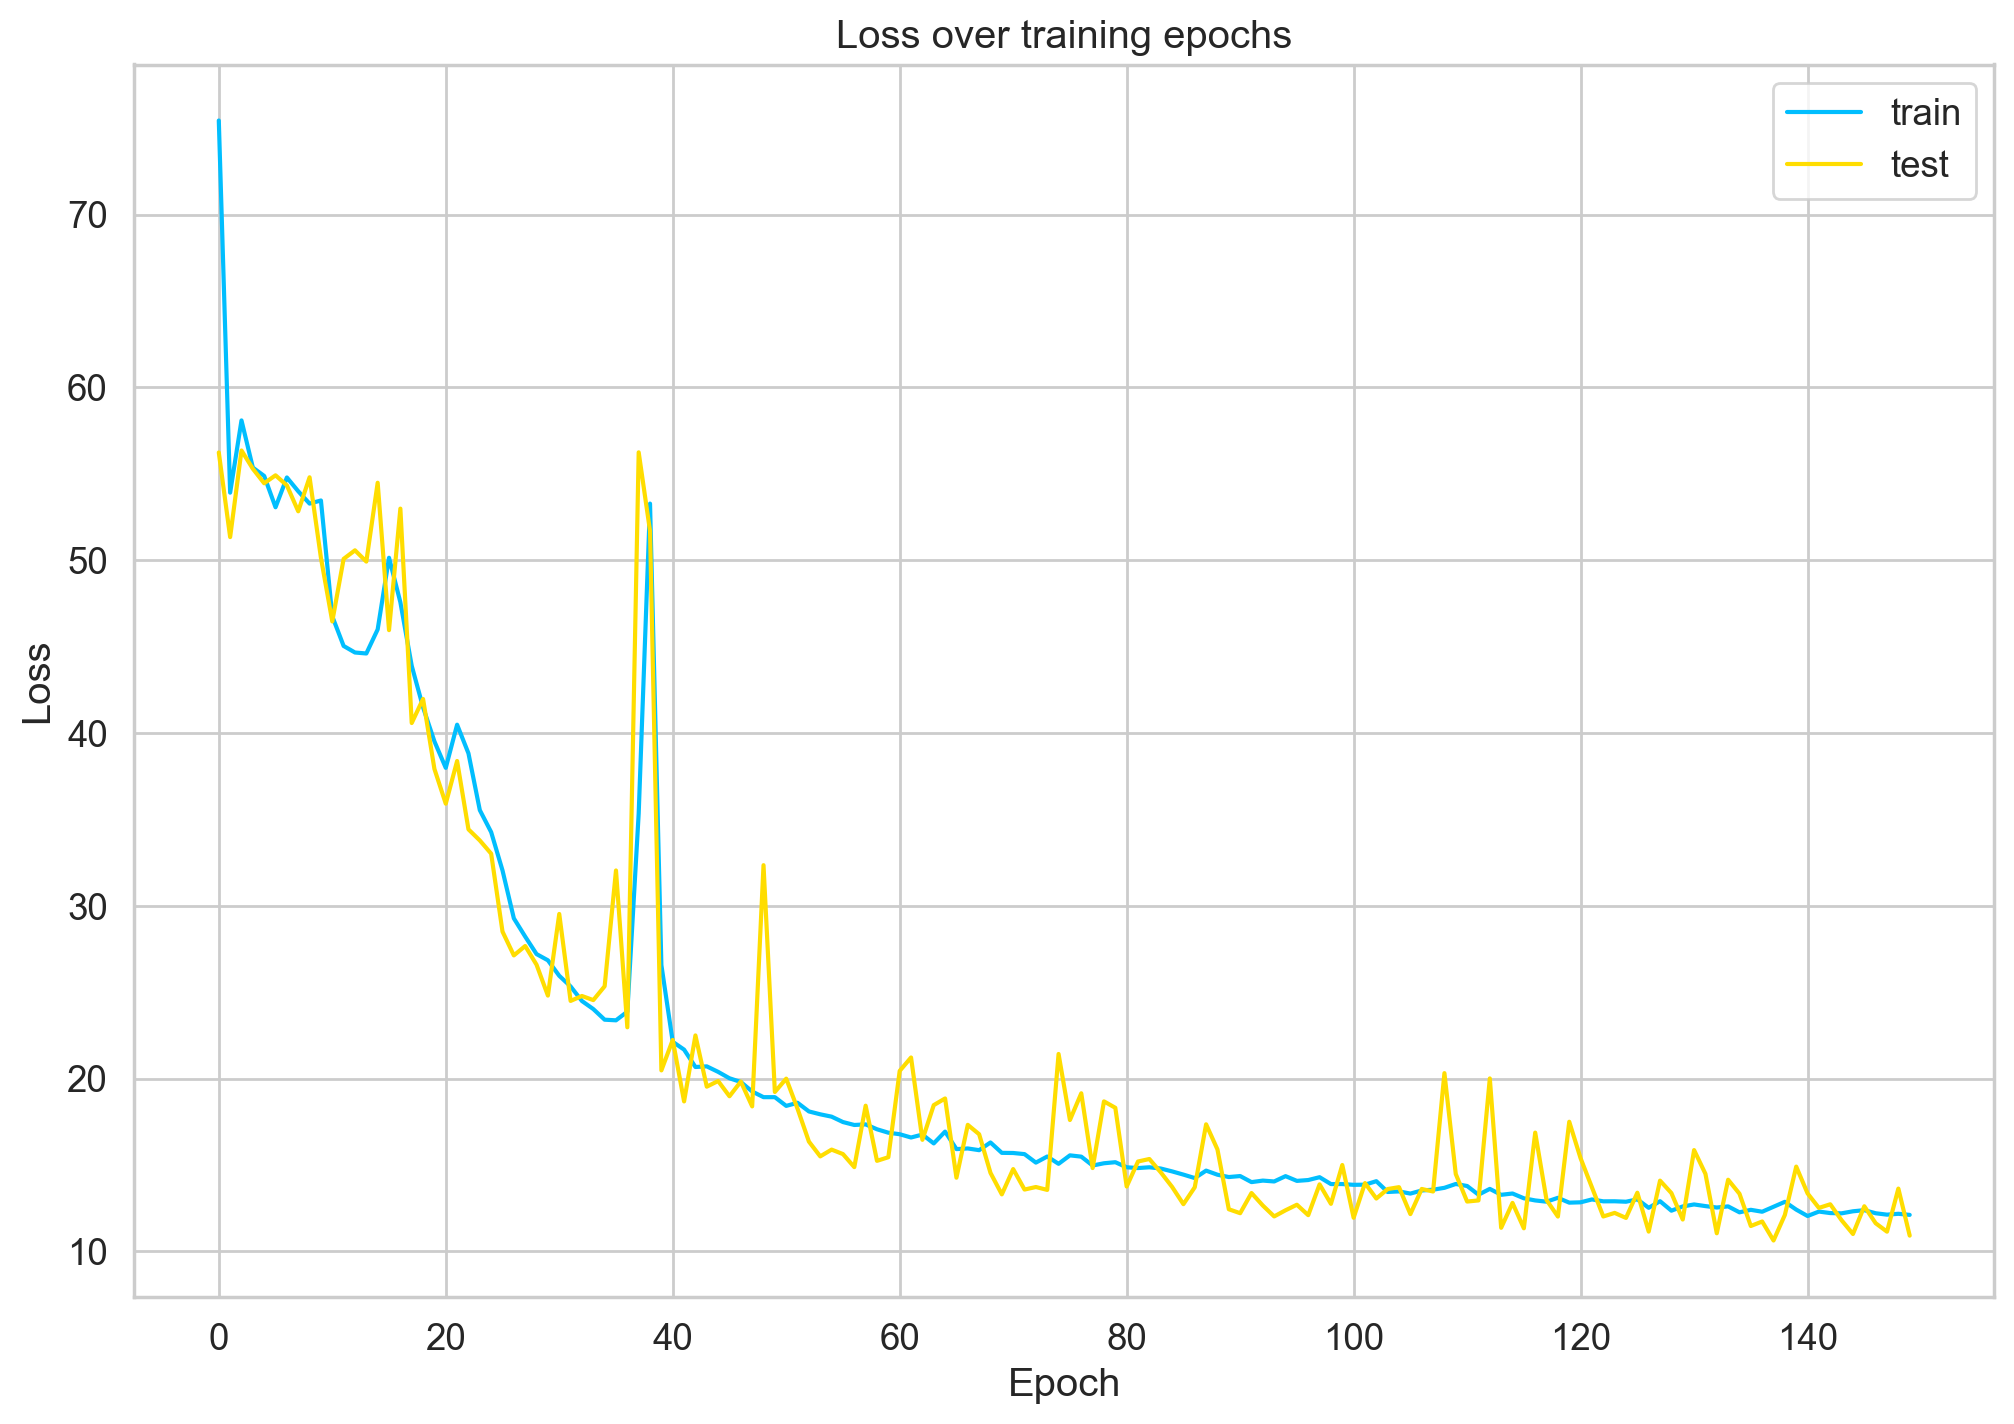

In [34]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

# Saving the model

In [36]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [37]:
# loading pre-trained model from checkpoint

# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

# Choosing a threshold
Writing a helper function to get predictions from our model

In [38]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction = 'sum').to(device) #L1 to gpu

  with torch.no_grad():
    model = model.eval()      # putting in evaluation mode          
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)  # calculating loss
      
      predictions.append(seq_pred.cpu().numpy().flatten()) # appending predictions & loss to results 
      losses.append(loss.item())
  return predictions, losses

In [39]:
_, losses = predict(model, train_dataset)

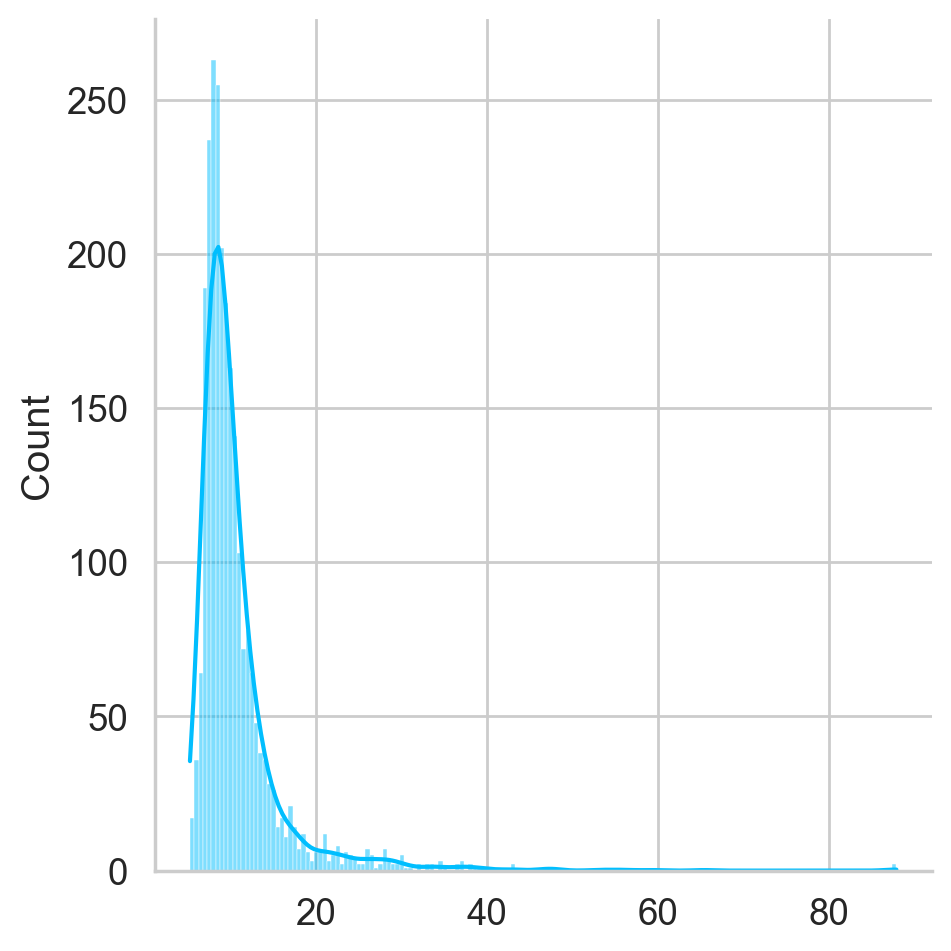

In [67]:
# plotting the loss/ reconstruction error
# sns.distplot(losses, bins= 50, kde= True)
sns.displot(losses, kde= True)

plt.show()

The majority of the loss (reconstruction error) seems to be below 25. So normal heartbeat threshold can be around 25.

Identifying false positives is okay but not detecting an anomaly can cause fatal outcome. So threshold should be low.

In [68]:
THRESHOLD = 26

# Evaluation¶
Using the threshold, we can turn the problem into a simple binary classification task:

* If the reconstruction loss for an example is below the threshold, we'll classify it as a normal heartbeat
* Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

## Normal hearbeat Predictions¶
Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

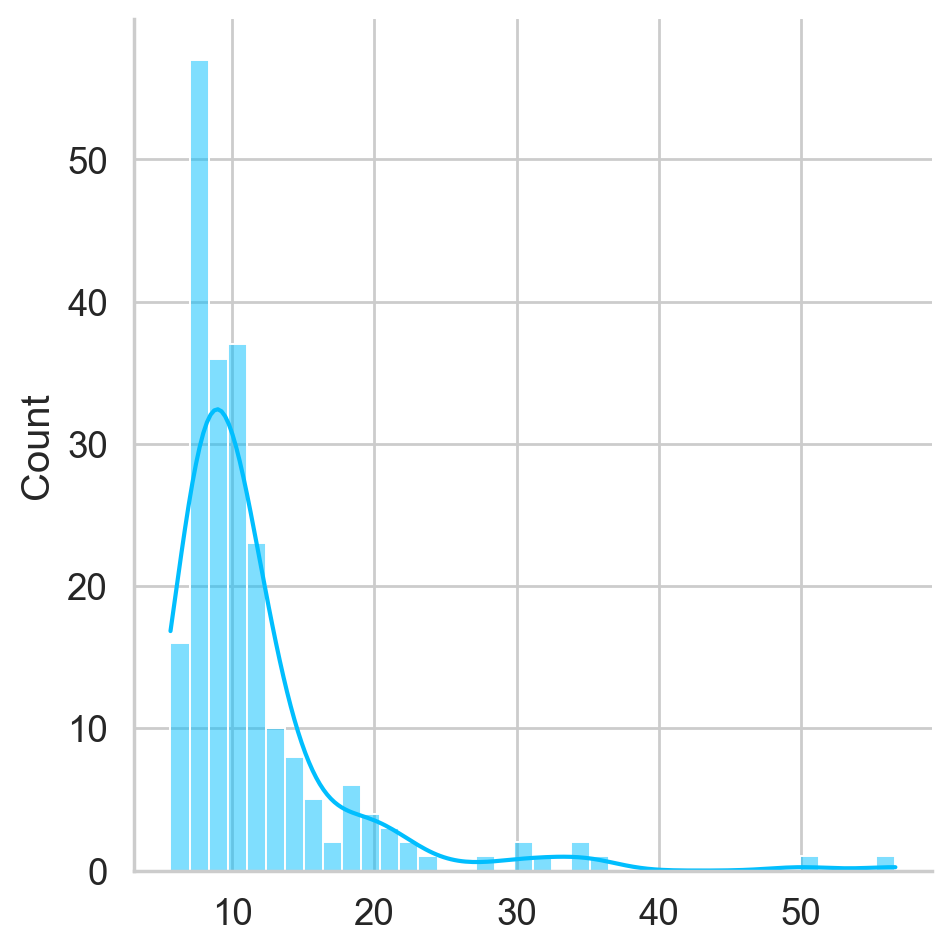

In [79]:
predictions, pred_losses = predict(model, test_normal_dataset)

# sns.distplot(pred_losses, bins= 50, kde= True);
# sns.displot(pred_losses, bins= 50, kde= True);
sns.displot(pred_losses, kde= True);
plt.show()

In [80]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct/normal precitions: {correct}/{len(test_normal_dataset)}')

Correct/normal precitions: 210/219


## Anomaly predictions

In [90]:
plt.close('all')

In [93]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
predictions, pred_losses = predict(model, anomaly_dataset)
# sns.distplot(pred_losses, bins= 50, kde= True);

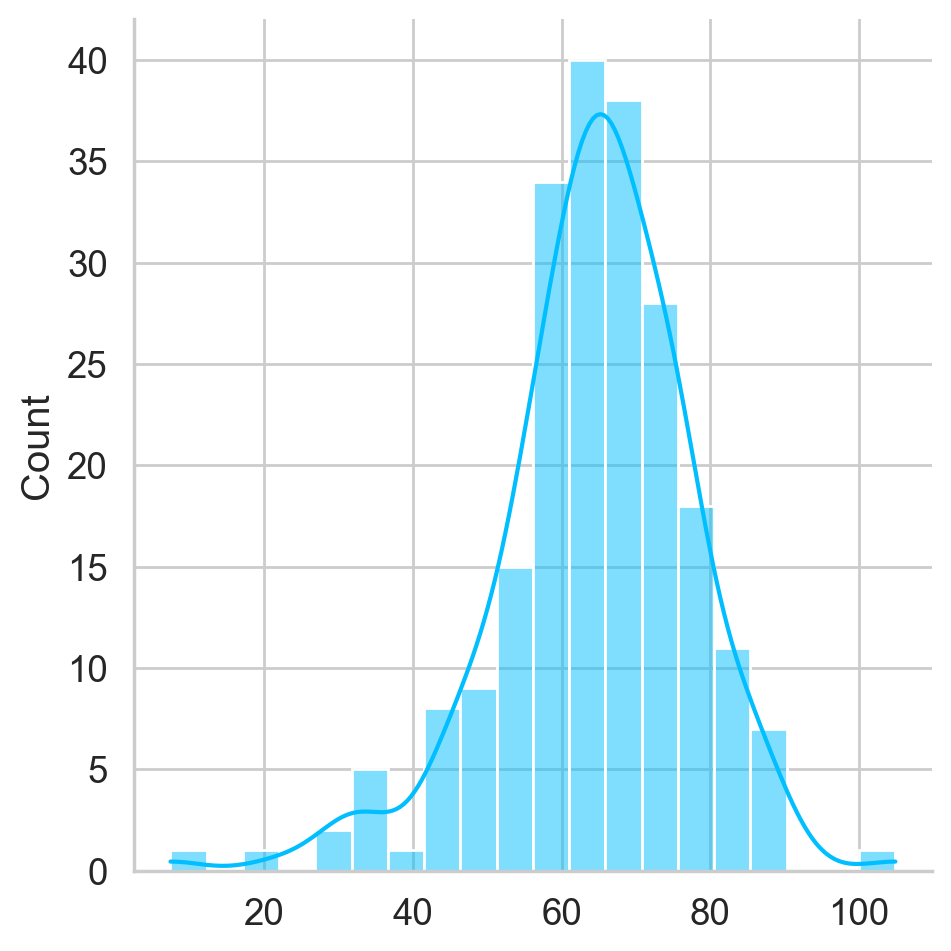

In [94]:
sns.displot(pred_losses,  kde=True)
plt.show()

Seems like majority of the reconstruction error of heartbeat examples of the test set are below threshold 26, whereas occasionally some still have more reconstruction error.

In [46]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct/anomaly precitions: {correct}/{len(anomaly_dataset)}')

Correct/anomaly precitions: 217/219


# Looking at Examples¶
We can compare the real and reconstructed Time Series values to see how close they are.

In [75]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label= 'true')
    ax.plot(predictions[0], label= 'predicted')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})') # showing loss in the title with 2 decimal points
    ax.legend()

In [76]:
plt.close('all')

In [77]:

# 1st row is 6 examples from normal heartbeat, next row represents anomalies
fig, axs = plt.subplots(
    nrows= 2,
    ncols= 6,
    sharex = True,
    sharey = True,
    figsize = (16, 6)
)

# looping through 6 examples
for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title= 'Normal', ax = axs[0, i])
    
for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title= 'Anomaly', ax = axs[1, i])

fig.tight_layout();

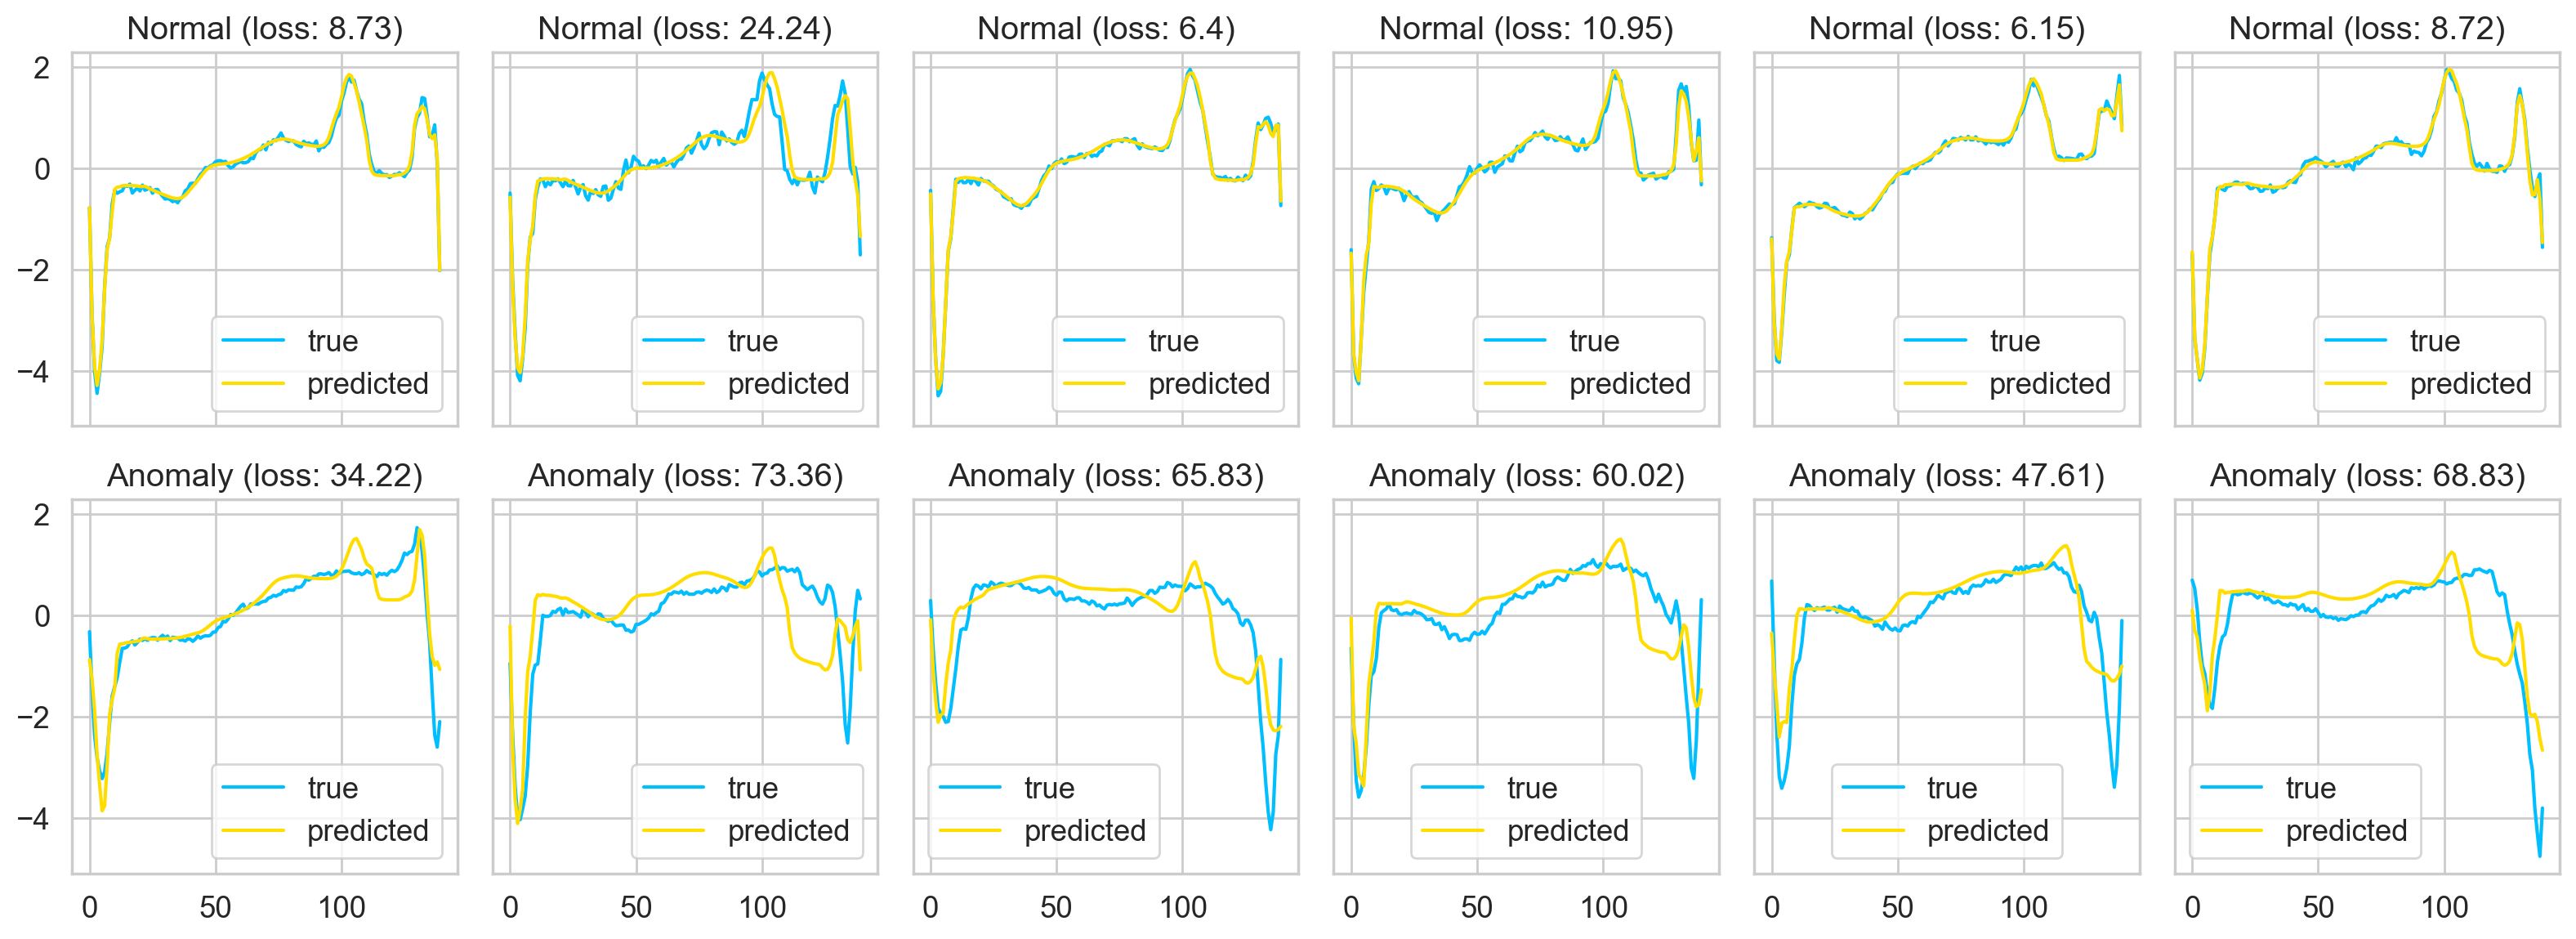

In [78]:
plt.show()

The Autoencoder can predict the normal heartbeats almost accurately with minimum reconstruction error. However, they performed very bad in reconstructing the anomaly data for the examples.

So, we can confidently say these heartbeats are anomalies and the model can successfully detect anomalies on this ECG data.

In [96]:
from tsai.all import *
computer_setup()

os              : macOS-15.3-arm64-arm-64bit
python          : 3.12.9
tsai            : 0.3.9
fastai          : 2.7.18
fastcore        : 1.7.29
torch           : 2.2.2
device          : mps
cpu cores       : 8
threads per cpu : 1
RAM             : 16.0 GB
GPU memory      : N/A
